In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

os.sys.path.append(os.path.dirname(os.path.abspath('..')))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch32_224 as vit_new
    # from util.attribution_methods.VIT_LRP.ViT_LRP_timm import vit_base_patch32_224 as vit_LRP
    # num_patches = 7

    from util.attribution_methods.VIT_LRP.ViT_new_timm import vit_base_patch16_224 as vit_new
    from util.attribution_methods.VIT_LRP.ViT_LRP_timm import vit_base_patch16_224 as vit_LRP
    num_patches = 14


from util.attribution_methods.VIT_LRP.ViT_explanation_generator import Baselines, LRP
from util.attribution_methods.ViT_CX.ViT_CX import ViT_CX
from util.attribution_methods.TIS import TIS
from util.attribution_methods import MDAFunctions
from util.attribution_methods import saliencyMethods
from util.test_methods import MASTestFunctions as MAS
from util import model_utils
from util.visualization import attr_to_subplot
from torchvision import models
from torch import nn

device = "cuda:0"

# Model
model = vit_new(pretrained=True).cuda()
model_lrp = vit_LRP(pretrained=True).cuda()

explainer = Baselines(model)
LRP_explainer = LRP(model_lrp)

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

downsize = transforms.Resize((num_patches, num_patches), antialias = True,  interpolation=transforms.InterpolationMode.NEAREST_EXACT)
resize = transforms.Resize((224, 224), antialias = True)
resize_exact = transforms.Resize((224, 224), antialias = True, interpolation=transforms.InterpolationMode.NEAREST_EXACT)

def heatmap_overlap(img, attr, name, alpha = 0.6, cmap = 'jet'):
    attr = attr.detach().cpu().numpy()
    fig, axs = plt.subplots(1, 1)
    attr_to_subplot(attr, name, axs, cmap = cmap, norm = 'absolute', blended_image = img, alpha = alpha)
    return

# heatmap
def heatmap_overlap_axs(img, attr, name, axs, alpha = 1, cmap = 'jet'):
    attr = attr.detach().cpu().numpy()
    attr_to_subplot(attr, name, axs, cmap = cmap, norm = 'absolute', blended_image = img, alpha = alpha)
    return

/usr/lib/python3/dist-packages/mpl_toolkits/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)
/home/chasewalker/Desktop/XAIcode/.venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
image_path = "../../../ImageNet/ILSVRC2012_val_00000040.JPEG"
# image_path = "zebra_0.jpg"

0.65886813
garden spider 74


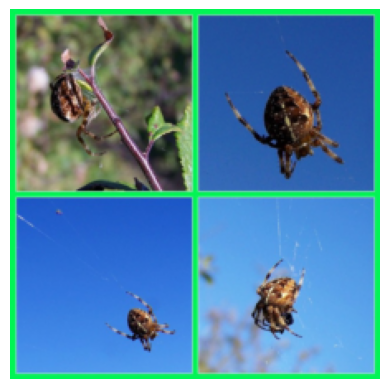

In [3]:
img = Image.open(image_path)
if img.mode != "RGB":
    img = img.convert("RGB")
trans_img = transform(img)
input_tensor = normalize(trans_img).unsqueeze(0)

target_class = model_utils.getClass(input_tensor, model, 'cuda:0', k = 0)
print(model_utils.getPrediction(input_tensor.to(device), model, device, target_class)[0])
with open('../../util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]

print(name, target_class.item())

plt.imshow(np.transpose(trans_img.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

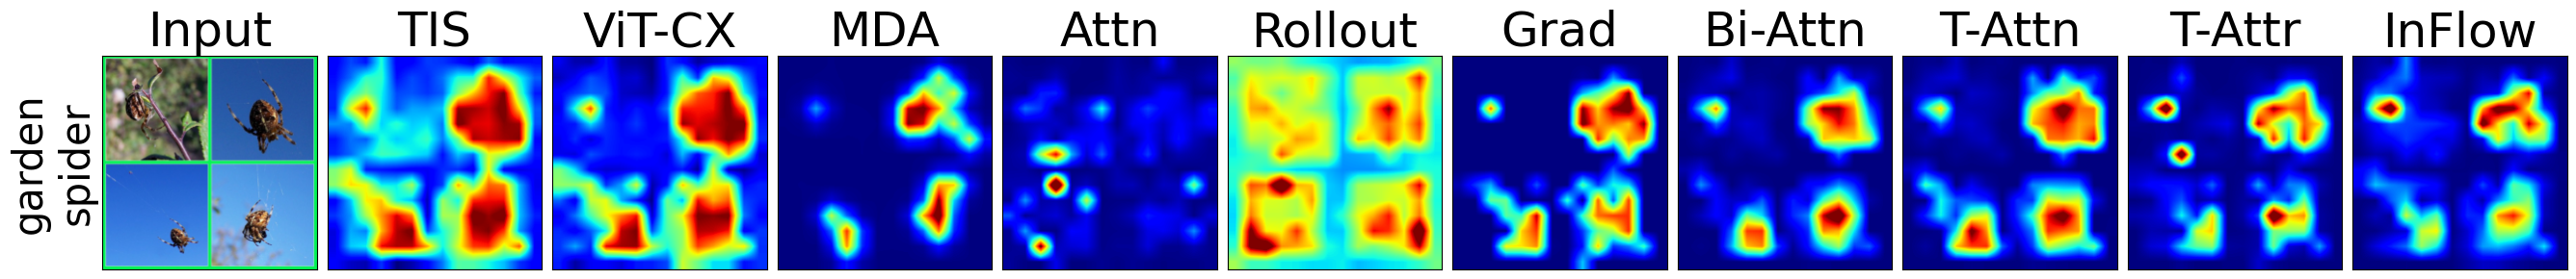

In [5]:
# Generate MDA
# Find minimum blur for model confidence < 1%
klen = 31
ksig = 31
kern = MAS.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)
blur_perc = model_utils.getPrediction(blur(input_tensor), model, "cuda:0", target_class)[0] * 100
while blur_perc > 1:
   klen += 4
   ksig += 4
   kern = MAS.gkern(klen, ksig)
   blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)
   blur_perc = model_utils.getPrediction(blur(input_tensor), model, "cuda:0", target_class)[0] * 100

bi_attn, _ = explainer.bidirectional(input_tensor.to("cuda:0"), target_class)
bi_attn = resize(bi_attn.cpu().detach()).permute(1, 2, 0).cpu().numpy() * np.ones((224, 224, 3))
mda, mda_smooth, _, _, _, mda_smooth_dense = MDAFunctions.MDA(trans_img, input_tensor.cpu(), bi_attn, num_patches ** 2, blur, model, "cuda:0", 224, max_batch_size = 5, vis = True)
mda = torch.from_numpy(mda)
mda_smooth = torch.from_numpy(mda_smooth)
mda_smooth_dense = torch.from_numpy(mda_smooth_dense)

attn = explainer.generate_raw_attn(input_tensor.to("cuda:0"), "cuda:0")
attn = resize(attn.cpu().detach()).permute(1, 2, 0)

attn_grad = explainer.generate_grad(input_tensor.to("cuda:0"), target_class, "cuda:0")
attn_grad = resize(attn_grad.cpu().detach()).permute(1, 2, 0)

naive_rollout, _, _ = explainer.generate_naive_rollout(input_tensor.to("cuda:0"))
naive_rollout = resize(naive_rollout.cpu().detach()).permute(1, 2, 0)

rollout, _, _ = explainer.generate_rollout(input_tensor.to("cuda:0"))
rollout = resize(rollout.cpu().detach()).permute(1, 2, 0)

bi_attn, _ = explainer.bidirectional(input_tensor.to("cuda:0"), target_class)
bi_attn = resize(bi_attn.cpu().detach()).permute(1, 2, 0)

inflow, _ = explainer.generate_RAVE(input_tensor.to("cuda:0"), target_class, option='b')
inflow = resize(inflow.cpu().detach()).permute(1, 2, 0)

_, _, t_attn, _, _ = explainer.generate_transition_attention_maps(input_tensor.to("cuda:0"), target_class, start_layer = 0)
t_attn = resize(t_attn.cpu().detach()).permute(1, 2, 0)

IG = explainer.IG(input_tensor.to("cuda:0"), target_class)
IG = resize(IG.cpu().detach()).permute(1, 2, 0)

T_attr = LRP_explainer.generate_LRP(input_tensor.cuda(), target_class, method="transformer_attribution", start_layer = 7)
T_attr = resize(T_attr.cpu().detach()).permute(1, 2, 0)

target_layer = model.blocks[-1].norm1
result, features = ViT_CX(model, input_tensor, target_layer, gpu_batch=1, device = 'cuda:0')
vit_cx = (result.reshape((224, 224, 1)) * torch.ones((224, 224, 3)))
vit_cx = (vit_cx - vit_cx.min()) / (vit_cx.max() - vit_cx.min())

saliency_method = TIS(model, batch_size=64)
saliency_map = saliency_method(input_tensor.cuda(), class_idx=target_class).cpu()
tis = resize(saliency_map.reshape((-1, saliency_map.shape[0], saliency_map.shape[1])).detach()).permute(1, 2, 0)

plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 11, figsize = (33, 3))
attr_to_subplot(trans_img, "Input", axs[0], original_image = True)
heatmap_overlap_axs(trans_img, tis, 'TIS', axs[1])
heatmap_overlap_axs(trans_img, vit_cx, 'ViT-CX', axs[2])
heatmap_overlap_axs(trans_img, mda_smooth, 'MDA', axs[3])
heatmap_overlap_axs(trans_img, attn, 'Attn', axs[4])
heatmap_overlap_axs(trans_img, rollout, 'Rollout', axs[5])
heatmap_overlap_axs(trans_img, attn_grad, 'Grad', axs[6])
heatmap_overlap_axs(trans_img, bi_attn, 'Bi-Attn', axs[7])
heatmap_overlap_axs(trans_img, t_attn, 'T-Attn', axs[8])
heatmap_overlap_axs(trans_img, T_attr, 'T-Attr', axs[9])
heatmap_overlap_axs(trans_img, inflow, 'InFlow', axs[10])
axs[0].set_ylabel(name.replace(" ", "\n"))
plt.subplots_adjust(wspace = 0.05)
plt.show()
fig.savefig('my_plot.png', dpi=100, bbox_inches='tight')